# Simple NN

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
plt.style.use('seaborn')

# Data preparation

In [3]:
data = pd.read_csv('../../data/SamDysch_glucose_2-5-2022.csv', skiprows=[0])
data.index = pd.to_datetime(data['Device Timestamp'], format="%d-%m-%Y %H:%M")

/home/sdysch/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
# drop non-historic glucose records
data = data[data['Record Type'] == 0]

# only keep bg
to_keep = [
    'Historic Glucose mmol/L',
]
data = data[to_keep]

data = data.rename(columns={'Historic Glucose mmol/L': 'reading'})

data.head()

,reading
Device Timestamp,
2019-12-09 19:04:00,6.8
2019-12-09 19:20:00,7.6
2019-12-09 19:35:00,7.7
2019-12-09 19:50:00,7.2
2019-12-09 20:05:00,5.8


In [5]:
# drop NaNs
data = data.dropna()

# Setup hypo threshold

In [6]:
HYPO_THRESHOLD = 3.9
data['is_hypo'] = (data['reading'] < HYPO_THRESHOLD).astype(int)

In [7]:
# adding some time variables
data['hour'] = data.index.hour
data['day'] = data.index.dayofweek
data['month'] = data.index.month

# Encode hours

In [8]:
# OneHotEncode
# data = pd.get_dummies(data, prefix='hour', columns=['hour'])

# sin/cosine encode
data['sin_hour'] = np.sin(2 * np.pi * data['hour'] / 23)
data['cos_hour'] = np.cos(2 * np.pi * data['hour'] / 23)
data = data.drop(['hour'], axis='columns')
print(data.columns)

Index(['reading', 'is_hypo', 'day', 'month', 'sin_hour', 'cos_hour'], dtype='object')


# creating a lagged and rolling variables
* Was I hypo 15 mins ago? 30 mins ago? Etc
* Rolling average of last N readings
* Sign of gradient of last N readings:
    * I.e., is BG rising, falling, or stable?
    
## Lagged features

In [9]:
# create lags
# To ensure that we do not make a lag between periods of sensor non-usage, create a new df with the lagged indices & merge onto original data frame
def create_lag(df, lag):
    tolerance = 15 * lag
    freq = '15min'
    print(f'Creating lag of {tolerance} minutes')
    lagged_copy = df[['reading']].shift(lag, freq=freq)
    lagged_copy.rename(columns={'reading': f'lagged_reading_{lag}'}, inplace=True)
    
    merged = pd.merge_asof(df, lagged_copy, left_index=True, right_index=True, direction='backward', tolerance=pd.Timedelta(minutes=tolerance))
    # merged = pd.merge_asof(copy, lagged_copy, left_index=True, right_index=True, direction='backward')
    return merged

NLAGS = 8
for lag in range(1, NLAGS):
    data = create_lag(data, lag)

Creating lag of 15 minutes
Creating lag of 30 minutes
Creating lag of 45 minutes
Creating lag of 60 minutes
Creating lag of 75 minutes
Creating lag of 90 minutes
Creating lag of 105 minutes


In [10]:
# For ease of variable calculation, drop the nans
data = data.dropna()

In [11]:
# lagged hypo bools
for lag in range(1, NLAGS):
    data[f'is_lagged_hypo_{lag}'] = (data[f'lagged_reading_{lag}'] < HYPO_THRESHOLD).astype(int)

## Rolling features

In [12]:
# simple differences of lags - was reading higher, lower, or stable?
for lag in range(2, NLAGS):
    data[f'diff_{lag}'] = data['lagged_reading_1'] - data[f'lagged_reading_{lag}']

# gradients - how quick is BG changing?
interval = 15
for lag in range(2, NLAGS):
    data[f'rate_{lag}'] = data[f'diff_{lag}'] / (interval * lag)

## train, test, validation split

In [13]:
TRAIN_SPLIT = 0.5
VAL_SPLIT = 0.35
TEST_SPLIT = 0.15

In [14]:
itrain = int(TRAIN_SPLIT * len(data))
ival = int(VAL_SPLIT * len(data))
itest = int(TEST_SPLIT * len(data))

train_data = data.iloc[:itrain]
val_data = data.iloc[itrain:itrain + ival]
test_data = data.iloc[itrain + ival:]

# Variable selection

In [15]:
rates_and_diffs = [f'diff_{v}' for v in range(2, NLAGS)]
rates_and_diffs.extend([f'rate_{v}' for v in range(2, NLAGS)])

# to fairly compare with baseline, drop any historical variables with time delta < 45 mins
vars_to_drop = [
    'month',
    'day',
    'reading',
    'is_lagged_hypo_1',
    'is_lagged_hypo_2',
    'lagged_reading_1',
    'lagged_reading_2',
    
    'is_lagged_hypo_3',
    'is_lagged_hypo_4',
    'is_lagged_hypo_5',
    'is_lagged_hypo_6',
    'is_lagged_hypo_7',
]
vars_to_drop.extend(rates_and_diffs)

train_data = train_data.drop(vars_to_drop, axis='columns')
val_data = val_data.drop(vars_to_drop, axis='columns')
test_data = test_data.drop(vars_to_drop, axis='columns')

print(train_data.columns)
print(val_data.columns)
print(test_data.columns)

Index(['is_hypo', 'sin_hour', 'cos_hour', 'lagged_reading_3',
       'lagged_reading_4', 'lagged_reading_5', 'lagged_reading_6',
       'lagged_reading_7'],
      dtype='object')
Index(['is_hypo', 'sin_hour', 'cos_hour', 'lagged_reading_3',
       'lagged_reading_4', 'lagged_reading_5', 'lagged_reading_6',
       'lagged_reading_7'],
      dtype='object')
Index(['is_hypo', 'sin_hour', 'cos_hour', 'lagged_reading_3',
       'lagged_reading_4', 'lagged_reading_5', 'lagged_reading_6',
       'lagged_reading_7'],
      dtype='object')


In [16]:
target = 'is_hypo'

X_train = train_data.drop([target], axis='columns')
y_train = train_data[target]

X_val = val_data.drop(target, axis='columns')
y_val = val_data[target]

X_test = test_data.drop(target, axis='columns')
y_test = test_data[target]

print(X_train.columns)

Index(['sin_hour', 'cos_hour', 'lagged_reading_3', 'lagged_reading_4',
       'lagged_reading_5', 'lagged_reading_6', 'lagged_reading_7'],
      dtype='object')


# class weights

In [17]:
# Suggestion here is to scale both classes to 50% of total: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data
neg = y_train[y_train == 0].count()
pos = y_train[y_train == 1].count()
total = neg + pos

weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)
print(weight_for_0, weight_for_1)

0.5309312867003193 8.582431307243963


# model setup

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, LayerNormalization
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, TruePositives, FalseNegatives, TrueNegatives, FalsePositives, BinaryAccuracy, AUC

input_shape = (X_train.shape[1],)
activation = 'relu'
learning_rate = 0.001

optimizer = Adam(learning_rate=learning_rate)

# normalize data
norm_layer = Normalization()
norm_layer.adapt(X_train)


model = Sequential()
# preprocessing
model.add(norm_layer)

# FF part
model.add(Dense(40, input_shape=input_shape, activation='relu', kernel_regularizer='l2'))
model.add(Dropout(0.4))
model.add(LayerNormalization())
# model.add(Dense(20, activation='relu'))
model.add(Dense(10, activation='relu', kernel_regularizer='l2'))
model.add(Dense(1, activation='sigmoid'))

METRICS = [
      # TruePositives(name='tp'),
      # FalsePositives(name='fp'),
      # TrueNegatives(name='tn'),
      # FalseNegatives(name='fn'), 
      # BinaryAccuracy(name='accuracy'),
      Precision(name='precision'),
      Recall(name='recall'),
      # AUC(name='auc'),
      AUC(name='prc', curve='PR'), # precision-recall curve
]

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=METRICS)

model.summary()

2022-07-06 18:32:28.022653: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-06 18:32:28.022725: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-07-06 18:32:29.881382: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-06 18:32:29.881403: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-06 18:32:29.881421: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (sdysch-Lenovo-IdeaPad-S540-15IML): /proc/driver/nvidia/version does not exist
2022-07-06 18:32:29.881626: I tensorflow/cor

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 7)                 15        
_________________________________________________________________
dense (Dense)                (None, 40)                320       
_________________________________________________________________
dropout (Dropout)            (None, 40)                0         
_________________________________________________________________
layer_normalization (LayerNo (None, 40)                80        
_________________________________________________________________
dense_1 (Dense)              (None, 10)                410       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 836
Trainable params: 821
Non-trainable params: 15
_________________________________________________________

# fit model

In [19]:
# Need a relatively large batch size, to ensure a good chance that positive samples make it into each weight update
# batch_size = 128
batch_size = 64
epochs = 200
callbacks = None
class_weight = {
    0: weight_for_0,
    1: weight_for_1,
}
validation_data = (X_val, y_val)

history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    validation_data=validation_data,
    class_weight=class_weight,
    callbacks=callbacks,
    epochs=epochs,
    verbose=1,
    shuffle=True,
)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/200
323/323 [==============================] - 2s 3ms/step - loss: 0.7307 - precision: 0.1345 - recall: 0.8551 - prc: 0.2112 - val_loss: 0.6936 - val_precision: 0.1264 - val_recall: 0.9404 - val_prc: 0.4038
Epoch 2/200
323/323 [==============================] - 0s 2ms/step - loss: 0.5182 - precision: 0.2034 - recall: 0.8984 - prc: 0.3730 - val_loss: 0.4141 - val_precision: 0.2189 - val_recall: 0.8978 - val_prc: 0.4572
Epoch 3/200
323/323 [==============================] - 0s 2ms/step - loss: 0.4417 - precision: 0.2301 - recall: 0.8876 - prc: 0.4733 - val_loss: 0.3958 - val_precision: 0.2156 - val_recall: 0.9114 - val_prc: 0.4789
Epoch 4/200
323/323 [==============================] - 0s 2ms/step - loss: 0.4020 - precision: 0.2486 - recall: 0.8876 - prc: 0.4831 - val_loss: 0.3348 - val_precision: 0.2399 - val_recall: 0.8961 - val_prc: 0.4821
Ep

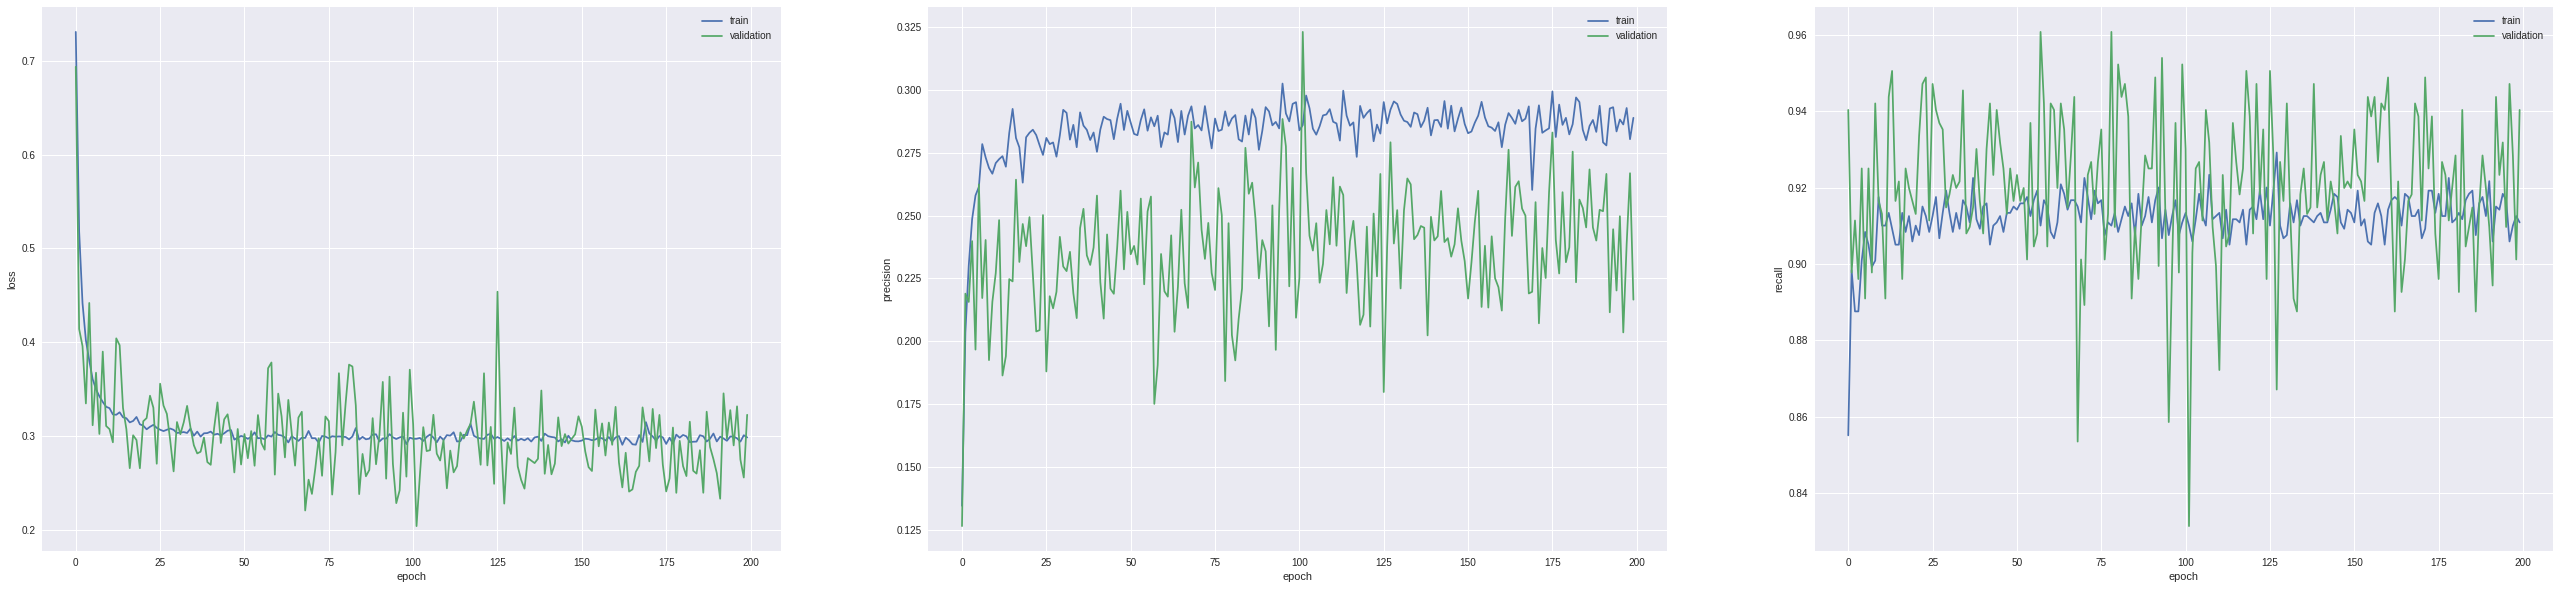

In [20]:
# learning curve
fig, ax = plt.subplots(1, 3, figsize=(45, 10))

ax[0].plot(history.history['loss'], label='train')
ax[0].plot(history.history['val_loss'], label='validation')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')
ax[0].legend(loc='best')

ax[1].plot(history.history['precision'], label='train')
ax[1].plot(history.history['val_precision'], label='validation')
ax[1].set_ylabel('precision')
ax[1].set_xlabel('epoch')
ax[1].legend(loc='best')

ax[2].plot(history.history['recall'], label='train')
ax[2].plot(history.history['val_recall'], label='validation')
ax[2].set_ylabel('recall')
ax[2].set_xlabel('epoch')
ax[2].legend(loc='best')

Accuracy: 0.8659877141933398
Precision: 0.17309697601668406
Recall: 0.8217821782178217
F1: 0.2859603789836348
F2: 0.4697226938313526


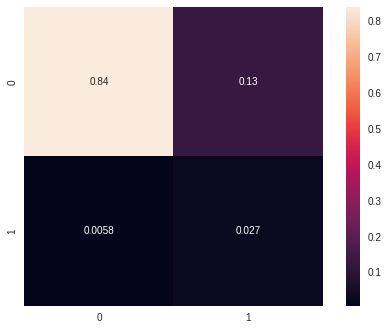

In [21]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, fbeta_score
y_pred = model.predict(X_test)
y_pred = y_pred > 0.5

print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred)}')
print(f'Recall: {recall_score(y_test, y_pred)}')
print(f'F1: {f1_score(y_test, y_pred)}')
print(f'F2: {fbeta_score(y_test, y_pred, beta=2)}')

cm = confusion_matrix(y_test, y_pred, normalize='all')
sns.heatmap(cm, annot=True, square=True)